# CS189 HW3
Timothy Quang Nguyen

timotqn2@uci.edu

## Environment Setup

In [1]:
# For package installations
!pip install xgboost
!pip install ucimlrepo

In [2]:
# Predict clinician scores for Parkinson's disease (regression prediction)

import numpy as np # for data organization
import pandas as pd # for data organization

import sklearn as sk # for machine learning
from sklearn.metrics import mean_squared_error, r2_score # For Evaluation
from sklearn.preprocessing import StandardScaler # To Scale Features
from sklearn.model_selection import GridSearchCV # For Hyper Parameter Tuning

from sklearn.linear_model import LinearRegression # For Linear Regression Classifier
from sklearn.tree import DecisionTreeRegressor # For Decision Tree Regressor
from sklearn.ensemble import RandomForestRegressor # For Random Forest Regressor
from sklearn.svm import SVR # For Support Vector Regression
from xgboost import XGBRegressor # For XGB Regressor

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# data (as pandas dataframes) 
X = parkinsons_telemonitoring.data.features 
y = parkinsons_telemonitoring.data.targets 
  
# metadata 
print(parkinsons_telemonitoring.metadata) 
  
# variable information 
print(parkinsons_telemonitoring.variables) 

{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'ID': 229, 'type': 'NATIVE', 'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig', 'venue': 'IEEE Transactions on Bio

## Function Declaration

In [4]:
# Used to produce confusion matrices and accuracy metrics for models
def confusion_matrix_and_metrics(y_te, y_pred):
    
    # Used to produce a pretty Confusion Matrix
    cm = confusion_matrix(y_te, y_pred, labels=[0, 1])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NO", ">30", "<30"], yticklabels=["NO", ">30", "<30"])
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Used to produce metric data, precision, recall, F1 score, accuracy

    print("Precision of the MLP :\t" + str(precision_score(y_te, y_pred, average="macro")))
    print("Recall of the MLP    :\t" + str(recall_score(y_te, y_pred, average="macro")))
    print("F1 Score of the Model :\t" + str(f1_score(y_te, y_pred, average="macro")))
    print("Accuracy Score of the Model :\t" + str(round(accuracy_score(y_te, y_pred) * 100, 2)) + "%")

## Data Exploration

In [5]:
data = pd.concat([X, y], axis = 1) # Combining both the x and y data for exploration

data

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS,total_UPDRS
0,72,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,...,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,0,28.199,34.398
1,72,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,...,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,0,28.447,34.894
2,72,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,...,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,0,28.695,35.389
3,72,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,...,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,0,28.905,35.810
4,72,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,...,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,0,29.187,36.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,61,142.7900,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,...,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,0,22.485,33.485
5871,61,149.8400,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,...,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,0,21.988,32.988
5872,61,156.8200,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,...,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,0,21.495,32.495
5873,61,163.7300,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,...,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,0,21.007,32.007


In [6]:
# General data properties

rows, cols = data.shape
column_names = data.columns.tolist()

print("Number of rows: ", rows)
print("Number of columns: ", cols)
print()
print("All Columns: ", column_names)
print()
print("Column Types: ", data.dtypes)

Number of rows:  5875
Number of columns:  21

All Columns:  ['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'sex', 'motor_UPDRS', 'total_UPDRS']

Column Types:  age                int64
test_time        float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
sex                int64
motor_UPDRS      float64
total_UPDRS      float64
dtype: object


In [7]:
# Display any missing data
data.isnull().sum()

age              0
test_time        0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
sex              0
motor_UPDRS      0
total_UPDRS      0
dtype: int64

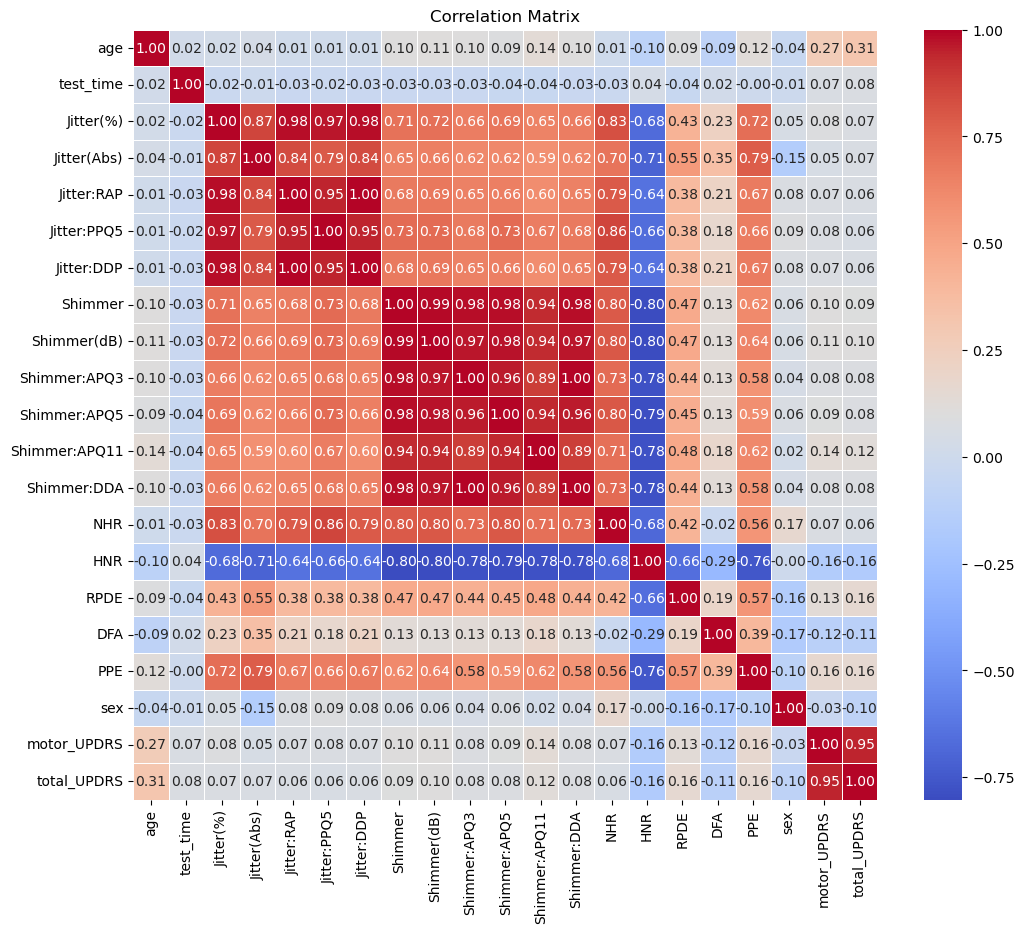

In [8]:
# Correlation heatmap for all columns
corr_matrix = data.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt="0.2f", linewidth=0.5)
plt.title("Correlation Matrix")
plt.show()

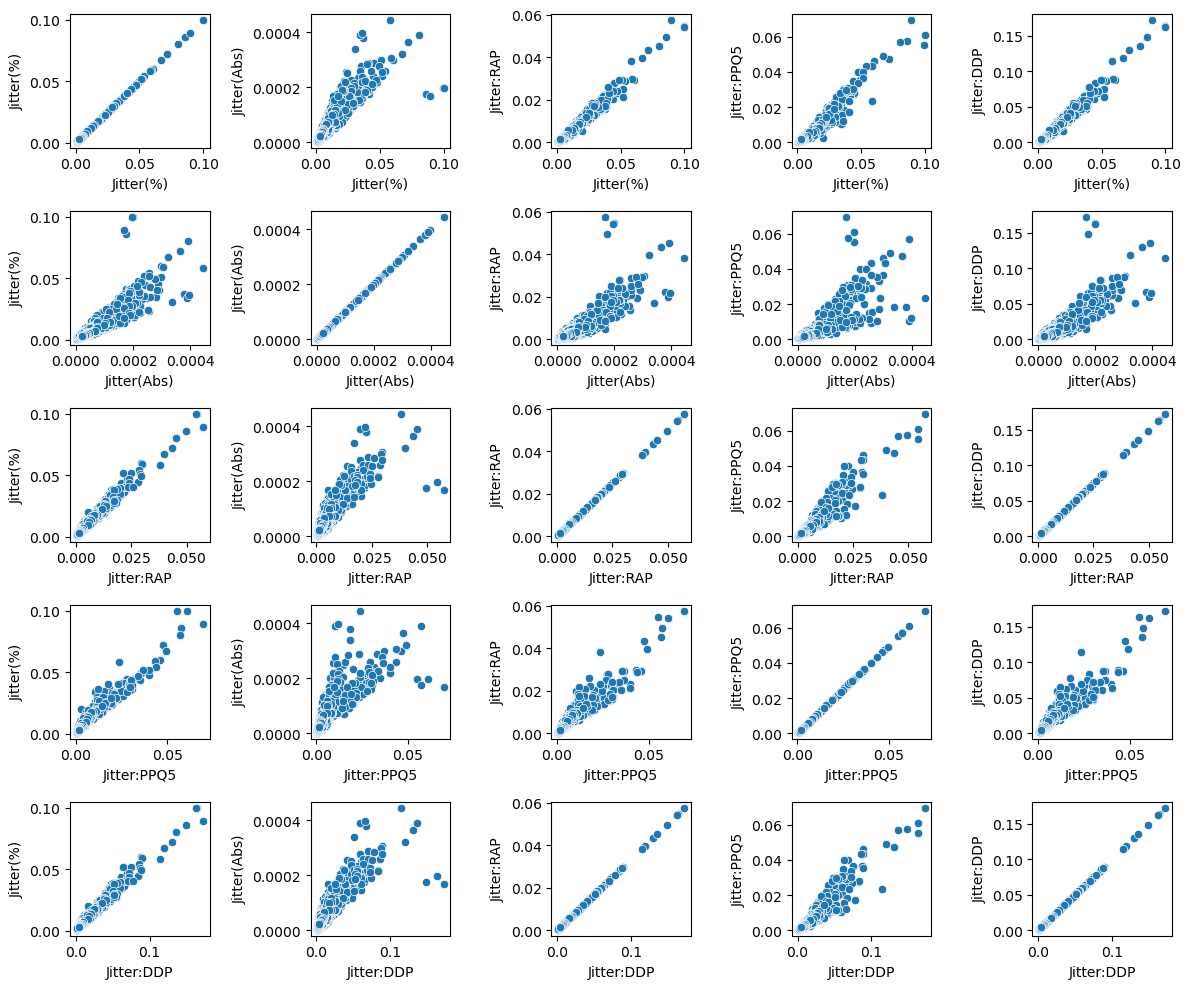

In [9]:
jitter_columns = ['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP']

fig, ax = plt.subplots(5, 5, figsize=(12, 10))

for index1, col1 in enumerate(jitter_columns):
    for index2, col2 in enumerate(jitter_columns):
        sns.scatterplot(data, x=col1, y=col2, ax=ax[index1][index2])

plt.tight_layout()
plt.show()

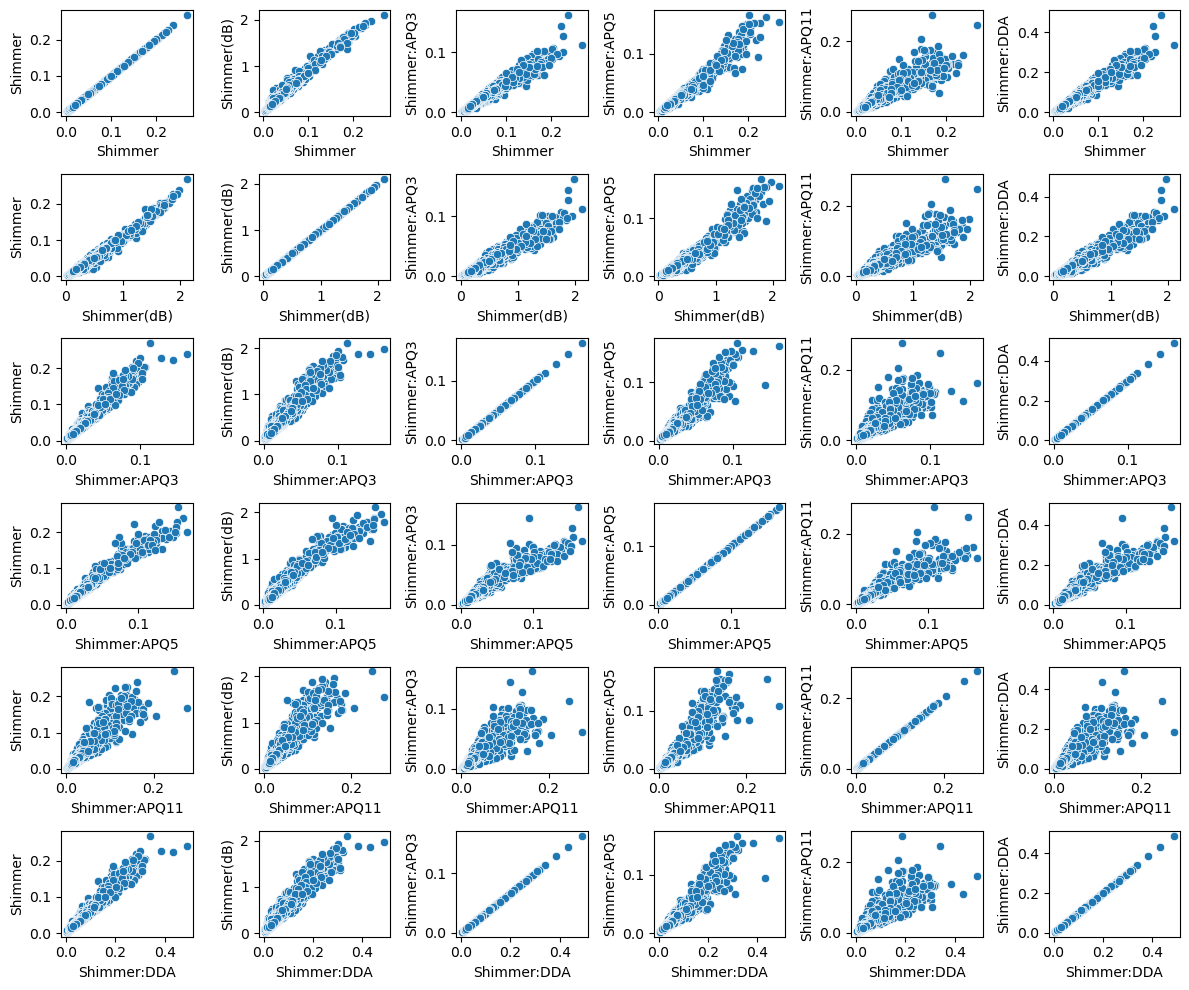

In [10]:
shimmer_columns = ['Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA']

fig, ax = plt.subplots(6, 6, figsize=(12, 10))

for index1, col1 in enumerate(shimmer_columns):
    for index2, col2 in enumerate(shimmer_columns):
        sns.scatterplot(data, x=col1, y=col2, ax=ax[index1][index2])

plt.tight_layout()
plt.show()

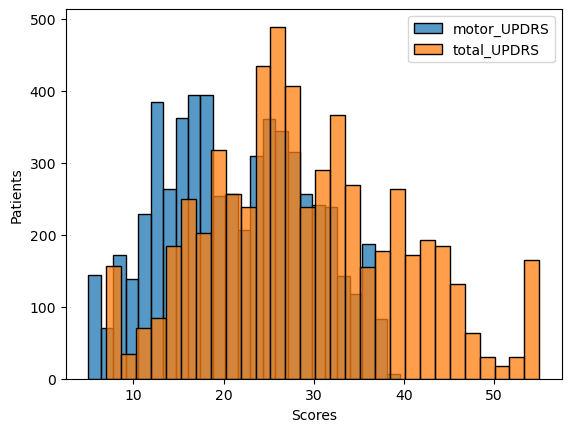

In [11]:
sns.histplot(data['motor_UPDRS'], label='motor_UPDRS')
sns.histplot(data['total_UPDRS'], label='total_UPDRS')

plt.xlabel('Scores')
plt.ylabel('Patients')
plt.legend()
plt.show()

## Data Preprocessing

### Combine Target Columns

In [12]:
y_data = pd.DataFrame(y[['motor_UPDRS', 'total_UPDRS']].sum(axis=1)) / 2
y_data.columns = ['Target']

y_data

,Target
0,31.2985
1,31.6705
2,32.0420
3,32.3575
4,32.7810
...,...
5870,27.9850
5871,27.4880
5872,26.9950
5873,26.5070


### Scale Features

In [13]:
scaler = StandardScaler()
x_data = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

x_data

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex
0,0.815695,-1.632090,0.082905,-0.284379,0.327453,-0.028637,0.328505,-0.324594,-0.351642,-0.209709,-0.423356,-0.543466,-0.209704,-0.298721,-0.009205,-1.214066,-1.478500,-0.650658,-0.682509
1,0.815695,-1.500676,-0.560793,-0.756869,-0.533746,-0.476212,-0.534825,-0.534016,-0.573156,-0.545158,-0.565592,-0.529955,-0.545153,-0.351965,1.282650,-1.055119,-1.247880,-1.218585,-0.682509
2,0.815695,-1.369410,-0.238944,-0.540080,-0.300038,-0.320767,-0.298983,-0.669115,-0.564469,-0.741592,-0.702426,-0.645545,-0.741587,-0.199370,0.318711,-0.784860,-1.540139,-0.103280,-0.682509
3,0.815695,-1.257773,-0.155370,-0.484493,-0.344859,-0.170682,-0.344871,-0.423692,0.069668,-0.460540,-0.449763,-0.392849,-0.460787,-0.071754,0.644530,-0.536487,-1.062115,1.237075,-0.682509
4,0.815695,-1.108169,-0.498557,-0.665151,-0.658604,-0.529814,-0.659682,-0.658276,-0.586186,-0.783145,-0.651413,-0.464905,-0.783392,-0.343370,1.036305,-0.689195,-1.297953,-0.283954,-0.682509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,-0.431361,0.934231,-0.372307,-0.359422,-0.421694,-0.427970,-0.422773,-0.583565,-0.655681,-0.561024,-0.528983,-0.600010,-0.560767,-0.116990,0.160696,0.997028,-1.411923,-0.064697,-0.682509
5871,-0.431361,1.066152,-0.566128,-0.537300,-0.575365,-0.484252,-0.574309,-0.421369,-0.416793,-0.501338,-0.442561,-0.422372,-0.501081,-0.338311,0.281189,-0.153430,-1.242097,-1.020641,-0.682509
5872,-0.431361,1.196763,-0.473663,-0.537300,-0.469717,-0.377049,-0.469728,-0.350143,-0.290834,-0.260328,-0.335135,-0.435882,-0.260576,-0.241573,0.789028,-0.629379,-1.048856,-0.852755,-0.682509
5873,-0.431361,1.326064,-0.594579,-0.659592,-0.546552,-0.473532,-0.547630,-0.743051,-0.781639,-0.772568,-0.686822,-0.721104,-0.772815,-0.404372,0.639170,0.269141,-1.269038,-0.847618,-0.682509


### Split Data

In [14]:
# Ratio 80% Training and 20% Testing
x_tr, x_te, y_tr, y_te = sk.model_selection.train_test_split(x_data, y_data, test_size=0.2, shuffle=True)

print(x_tr.shape)
print(x_te.shape)
print(y_tr.shape)
print(y_te.shape)

(4700, 19)
(1175, 19)
(4700, 1)
(1175, 1)


## Linear Regression

In [15]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(x_tr, y_tr)
lr_y_pred = lr_model.predict(x_te)

In [16]:
# Model Evaluation
lr_mse = mean_squared_error(y_te, lr_y_pred)
lr_r2 = r2_score(y_te, lr_y_pred)

print("MSE:", lr_mse)
print("R2 Score:", lr_r2)

MSE: 73.87982587272572
R2 Score: 0.15973962519120877


## Decision Tree Regressor

### Decision Tree Regressor (Default Hyperparameters)

In [17]:
# Decision Tree Regressor Model
dtr_model = DecisionTreeRegressor(random_state=0)
dtr_model.fit(x_tr, y_tr)
dtr_y_pred = dtr_model.predict(x_te)

In [18]:
# Model Evaluation
dtr_mse = mean_squared_error(y_te, dtr_y_pred)
dtr_r2 = r2_score(y_te, dtr_y_pred)

print("MSE:", dtr_mse)
print("R2 Score:", dtr_r2)

MSE: 3.2093845232148928
R2 Score: 0.963498578799742


### Decision Tree Regressor (Tuned Hyperparameters)

In [19]:
# Create a Decision Tree Regressor model and use Grid Search to find best combination of hyperparameters
dtr_model_tuned = DecisionTreeRegressor()
dtr_params = {"max_depth": [5, 10, 15, None], 
            "max_features": ["sqrt", "log2", 0.5, None],
            "min_samples_split": [1, 2, 4, 8], 
            "min_samples_leaf": [1, 2, 3, 4]}

dtr_model_tuned = GridSearchCV(dtr_model_tuned, dtr_params, verbose=3)
dtr_model_tuned.fit(x_tr, y_tr)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 4/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 5/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.175 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.077 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.359 total time=   0.0s
[C

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
320 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 10, 15, None],
                         'max_features': ['sqrt', 'log2', 0.5, None],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 4, 8]},
             verbose=3)

In [20]:
# Decision Tree Regressor Model
dtr_model_tuned = DecisionTreeRegressor(random_state=0, min_samples_split=8)
dtr_model_tuned.fit(x_tr, y_tr)
dtr_tuned_y_pred = dtr_model_tuned.predict(x_te)

In [21]:
# Model Evaluation
dtr_tuned_mse = mean_squared_error(y_te, dtr_tuned_y_pred)
dtr_tuned_r2 = r2_score(y_te, dtr_tuned_y_pred)

print("MSE:", dtr_tuned_mse)
print("R2 Score:", dtr_tuned_r2)

MSE: 2.9938834575170468
R2 Score: 0.9659495456786693


## Random Forest Regressor

### Random Forest Regressor (Default Hyperparameters)

In [22]:
# Random Forest Regressor Model
rfr_model = RandomForestRegressor(random_state=0)
rfr_model.fit(x_tr, y_tr.values.ravel())
rfr_y_pred = rfr_model.predict(x_te)

In [23]:
# Model Evaluation
rfr_mse = mean_squared_error(y_te, rfr_y_pred)
rfr_r2 = r2_score(y_te, rfr_y_pred)

print("MSE:", rfr_mse)
print("R2 Score:", rfr_r2)

MSE: 2.04940777766596
R2 Score: 0.9766913886564346


### Random Forest Regressor (Tuned Hyperparameters)

In [ ]:
# Create a Random Forest Regressor model and use Grid Search to find best combination of hyperparameters
rfr_model_tuned = RandomForestRegressor()
rfr_params = {"n_estimators": [20, 50, 100, 200], 
              "max_features": ["sqrt", "log2", 0.5, 1],
              "max_depth": [5, 10, 15, None], 
              "min_samples_leaf": [1, 2, 3, 4]}

rfr_model_tuned = GridSearchCV(rfr_model_tuned, rfr_params, verbose=3)
rfr_model_tuned.fit(x_tr, y_tr.values.ravel())

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.346 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.391 total time=   0.1s
[CV 3/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.383 total time=   0.1s
[CV 4/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.351 total time=   0.1s
[CV 5/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.370 total time=   0.1s
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=50;, score=0.348 total time=   0.3s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=50;, score=0.382 total time=   0.3s
[CV 3/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=50;, score=0.417 total time=   0.3s
[CV 4/5] END max_depth=5

In [ ]:
# Random Forest Regressor Model
rfr_model_tuned = RandomForestRegressor(max_features=0.5, n_estimators=200, random_state=0)
rfr_model_tuned.fit(x_tr, y_tr.values.ravel())
rfr_tuned_y_pred = rfr_model_tuned.predict(x_te)

In [ ]:
# Model Evaluation
rfr_tuned_mse = mean_squared_error(y_te, rfr_tuned_y_pred)
rfr_tuned_r2 = r2_score(y_te, rfr_tuned_y_pred)

print("MSE:", rfr_tuned_mse)
print("R2 Score:", rfr_tuned_r2)

## Support Vector Regressor (SVR)

### SVR (Default Hyperparameters)

In [ ]:
# SVR Model
svr_model = SVR()
svr_model.fit(x_tr, y_tr.values.ravel())
svr_y_pred = svr_model.predict(x_te)

In [ ]:
# Model Evaluation
svr_mse = mean_squared_error(y_te, svr_y_pred)
svr_r2 = r2_score(y_te, svr_y_pred)

print("MSE:", svr_mse)
print("R2 Score:", svr_r2)

### SVR (Tuned Hyperparameters)

In [ ]:
# Create a SVR model and use Grid Search to find best combination of hyperparameters
svr_model_tuned = SVR()
svr_params = {"C": [0.1, 1, 10, 50, 100], 
              "gamma": ["scale", "auto"],
              "epsilon": [0.001, 0.01, 0.1, 1], 
              "kernel": ["linear", "poly", "rbf", "sigmoid"]}

svr_model_tuned = GridSearchCV(svr_model_tuned, svr_params, verbose=3)
svr_model_tuned.fit(x_tr, y_tr.values.ravel())

In [ ]:
# SVR Model
svr_model_tuned = SVR(C=100, epsilon=1)
svr_model_tuned.fit(x_tr, y_tr.values.ravel())
svr_tuned_y_pred = svr_model_tuned.predict(x_te)

In [ ]:
# Model Evaluation
svr_tuned_mse = mean_squared_error(y_te, svr_tuned_y_pred)
svr_tuned_r2 = r2_score(y_te, svr_tuned_y_pred)

print("MSE:", svr_tuned_mse)
print("R2 Score:", svr_tuned_r2)

## XGB Regressor

### XGB Regressor (Default Hyperparameters)

In [ ]:
# XGB Regressor Model
xgb_model = XGBRegressor(random_state=0)
xgb_model.fit(x_tr, y_tr)
xgb_y_pred = xgb_model.predict(x_te)

In [ ]:
# Model Evaluation
xgb_mse = mean_squared_error(y_te, xgb_y_pred)
xgb_r2 = r2_score(y_te, xgb_y_pred)

print("MSE:", xgb_mse)
print("R2 Score:", xgb_r2)

### XGB Regressor (Tuned Hyperparameters)

In [ ]:
# Create a XGB Regressor model and use Grid Search to find best combination of hyperparameters
xgb_model_tuned = XGBRegressor()
xgb_params = {"n_estimators": [20, 50, 100, 200], 
              "eta": [0.01, 0.1, 0.3, 0.5],
              "max_depth": [3, 6, 9], 
              "subsample": [0.3, 0.5, 1], 
              "colsample_bytree": [0.3, 0.5, 1]}

xgb_model_tuned = GridSearchCV(xgb_model_tuned, xgb_params, verbose=3)
xgb_model_tuned.fit(x_tr, y_tr)
xgb_model_tuned.best_params_

In [ ]:
# XGB Regressor Model
xgb_model_tuned = XGBRegressor(n_estimators=200, eta=0.1, max_depth=9, subsample=1, colsample_bytree=1, random_state=0)
xgb_model_tuned.fit(x_tr, y_tr)
xgb_tuned_y_pred = xgb_model_tuned.predict(x_te)

In [ ]:
# Model Evaluation
xgb_tuned_mse = mean_squared_error(y_te, xgb_tuned_y_pred)
xgb_tuned_r2 = r2_score(y_te, xgb_tuned_y_pred)

print("MSE:", xgb_tuned_mse)
print("R2 Score:", xgb_tuned_r2)

## Model Comparison

In [ ]:
model_type = ["LR Default", 
          "DTR Default", 
          "DTR Tuned", 
          "RFR Default", 
          "RFR Tuned", 
          "SVR Default", 
          "SVR Tuned",
          "XGB Default", 
          "XGB Tuned"]

mses = [lr_mse, dtr_mse, dtr_tuned_mse, rfr_mse, rfr_tuned_mse, svr_mse, svr_tuned_mse, xgb_mse, xgb_tuned_mse]
r2_scores = [lr_r2, dtr_r2, dtr_tuned_r2, rfr_r2, rfr_tuned_r2, svr_r2, svr_tuned_r2, xgb_r2, xgb_tuned_r2]

models = ["Linear Regression", 
          "Decision Tree Regressor", "Decision Tree Regressor", 
          "Random Forest Regressor", "Random Forest Regressor",
          "SVR", "SVR",
          "XGB Regressor", "XGB Regressor"]

comparison_data = pd.DataFrame({"Model Type": model_type, "MSE": mses, "R2 Scores": r2_scores, "Model": models})

fig, ax = plt.subplots(2, 1, figsize=(15, 6))

sns.barplot(x="Model Type", y="MSE", data=comparison_data, hue="Model", ax=ax[0])
sns.barplot(x="Model Type", y="R2 Scores", data=comparison_data, hue="Model", ax=ax[1])
plt.tight_layout()
plt.show()

### Discussion

For regression of Parkinson's Disease clinical data prediction there is a clear contrast in performance between different models. Both Linear Regression and Support Vector Regression (SVR) performed significantly worst with mean squared errors above 50 with there default models. They also had r2 scores below 40%. r2 scores represent the variance of regression models and are good indicators of their accuracy. These values are unacceptable for the prediction as the range of values we are targeting are all between 0 and 50. On the other hand the Decision Tree, Random Forest, and XGB Regressors all performed very well in their default with mean squared errors below 4 and r2 scores above 90%. All models except Linear Regression have tuned hyperparameter versions which were found with Grid Search Cross Validation. Linear Regression doesn't have hyperparameters to tune. Decision Tree and XGB Regressors saw a 1-2% increase in r2_score with tuned hyperparameters while Random Forest Regressor saw almost 6% drop. Mean square error scores also saw about a 1-2 point decrease in Decision Tree and XGB Regressors while Random Forest Regressor saw 5 point increase. SVR saw the most significant improvement in both r2 scores and mean squared error with tuned hyperparameters. Overall, the tuned hyperparameters have caused great improvements especially considering the targetted value's ranges. Random Forest's tuned model may be in outlier in its results and should be retested. The model with the highest score was the XGB Regressor with an r2_score of 97.4% and a mean squared error of 2.25. The stark difference between the well performing and not well performing models appears to be that well performing models follow tree-like prediction structure while not well performing models follow the graphical prediction structure. This shows that this issue is better suited to tree-like models that involve decision trees in their process.

### References

1. Sklearn SVR Documentation
2. Sklearn Random Forest Regressor Documentation
3. Sklearn Decision Tree Regressor Documentation
4. Geeksforgeeks XGB Regression
5. Machinelearningmastery XGB Regression

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

https://www.geeksforgeeks.org/xgboost-for-regression/

https://machinelearningmastery.com/xgboost-for-regression/